<a href="https://colab.research.google.com/github/BEMiklos/PlantTraits2024/blob/testing_vit/train_baselines_sceleton.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **PlantTraits**

### Imports

In [1]:
from google.colab import userdata

In [3]:
!pip install wandb -qU
# Log in to your W&B account
import wandb
wandb.login(key=userdata.get('wandb_key'))

wandb: W&B API key is configured. Use `wandb login --relogin` to force relogin
wandb: WARNING If you're specifying your api key in code, ensure this code is not shared publicly.
wandb: WARNING Consider setting the WANDB_API_KEY environment variable, or running `wandb login` from the command line.
wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


True

In [4]:
!pip install -q kaggle
!pip install -q albumentations

In [5]:
!pip install -q optuna

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 380.1/380.1 kB 2.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 233.4/233.4 kB 12.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 78.8/78.8 kB 7.9 MB/s eta 0:00:00


TODO befor running:Create New API Token and add it as kaggle.json to root

In [6]:
!mkdir ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

In [7]:
!kaggle competitions download -c planttraits2024

 99% 3.15G/3.17G [00:37<00:00, 127MB/s]
100% 3.17G/3.17G [00:37<00:00, 89.8MB/s]


In [8]:
!unzip -q '/content/planttraits2024.zip'

In [10]:
import random

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import albumentations as A
import cv2

import torch
from torch import nn
import torch.nn.functional as F
from torch.optim.lr_scheduler import OneCycleLR
from torchvision.io import read_image
from torch.utils.data import Dataset, ConcatDataset, DataLoader, Subset, random_split
from torchvision import transforms

from sklearn.model_selection import train_test_split

import re

import optuna

### Set the Device

In [11]:
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
random_state = 7

np.random.seed(0)

random.seed(0)

torch.manual_seed(0)
torch.cuda.manual_seed(0)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

In [12]:
TRAIN_IMAGES_PATH = '/content/train_images'
TEST_IMAGES_PATH = '/content/test_images'

### Untility functions

In [13]:
mean_pattern = r'X\d+_mean'
sd_pattern = r'X\d+_sd'

In [14]:
def find_matching_elements(lst,pattern):
    matching_elements = [element for element in lst if re.search(pattern, element)]
    return matching_elements

In [15]:
train_df = pd.read_csv('train.csv')
test_df = pd.read_csv('test.csv')

In [16]:
train_df.sample(10)

,id,WORLDCLIM_BIO1_annual_mean_temperature,WORLDCLIM_BIO12_annual_precipitation,WORLDCLIM_BIO13.BIO14_delta_precipitation_of_wettest_and_dryest_month,WORLDCLIM_BIO15_precipitation_seasonality,WORLDCLIM_BIO4_temperature_seasonality,WORLDCLIM_BIO7_temperature_annual_range,SOIL_bdod_0.5cm_mean_0.01_deg,SOIL_bdod_100.200cm_mean_0.01_deg,SOIL_bdod_15.30cm_mean_0.01_deg,...,X18_mean,X26_mean,X50_mean,X3112_mean,X4_sd,X11_sd,X18_sd,X26_sd,X50_sd,X3112_sd
24886,184873835,-1.032917,574.295227,90.252380,62.482738,1227.480225,42.762859,87,144,125,...,0.174163,0.645791,0.433834,615.749773,NaN,NaN,NaN,NaN,NaN,NaN
31965,190494649,0.440794,589.538086,48.000000,33.024284,1090.136475,39.804287,54,149,118,...,0.554565,1.121493,1.130741,725.767936,0.002047,0.909884,0.073212,0.059998,0.042375,30.941051
28421,195642066,17.284445,341.909515,65.457146,89.490135,544.396545,31.776667,138,163,151,...,0.439074,0.601914,1.030841,304.821680,0.003821,0.326769,0.027901,0.153138,0.013564,16.485387
12674,164426751,12.075297,166.142853,24.500000,49.969826,902.658264,38.064285,129,148,141,...,0.199941,3.176854,2.202036,509.618373,NaN,NaN,NaN,NaN,NaN,NaN
31158,186882920,17.013542,1030.795898,266.556122,91.027039,177.292847,14.822959,107,117,112,...,0.231805,0.051018,1.190324,89.976644,0.005543,0.221099,0.025756,0.024287,0.015604,5.421096
45443,195637432,-0.526925,317.861908,87.438095,113.449104,1096.622192,40.898571,108,146,128,...,0.359241,1.062527,1.332752,3322.765956,NaN,NaN,NaN,NaN,NaN,NaN
19727,194871319,20.958969,2068.119141,264.828583,53.143101,488.990204,19.647144,115,144,128,...,0.232182,0.041521,2.149017,669.891966,NaN,NaN,NaN,NaN,NaN,NaN
20600,186386731,18.402203,563.590454,81.157143,64.466095,437.827026,24.329046,121,136,131,...,0.230897,0.500619,0.942541,608.056653,NaN,NaN,NaN,NaN,NaN,NaN
24052,164361896,17.402231,870.571411,82.178574,35.694508,825.165405,35.850002,148,174,162,...,0.283748,0.163265,1.672265,62.625917,NaN,NaN,NaN,NaN,NaN,NaN
35949,195065314,11.712444,437.182220,34.533333,28.756390,632.724487,29.993334,127,155,137,...,0.009491,0.147462,1.895993,9.095304,0.005892,0.749986,0.000848,0.008639,0.137162,1.257774


In [17]:
len(train_df.columns), len(test_df.columns)

(176, 164)

In [18]:
len(train_df), len(test_df)

(55489, 6545)

In [19]:
targets = [col for col in train_df.columns if col not in test_df.columns]
targets = targets[:6]

In [20]:
metadata_columns = [col for col in train_df.columns if col in test_df.columns and col != 'id']

 TODO: hiányzó értékek kezelésének pontosítása

In [21]:
# Check for missing values in the train DataFrame
train_missing_values = train_df.isnull().sum()
print("Missing values in Train DataFrame:")
print(train_missing_values)

Missing values in Train DataFrame:
id                                                                           0
WORLDCLIM_BIO1_annual_mean_temperature                                       0
WORLDCLIM_BIO12_annual_precipitation                                         0
WORLDCLIM_BIO13.BIO14_delta_precipitation_of_wettest_and_dryest_month        0
WORLDCLIM_BIO15_precipitation_seasonality                                    0
                                                                         ...  
X11_sd                                                                   16341
X18_sd                                                                   16341
X26_sd                                                                   16341
X50_sd                                                                   16341
X3112_sd                                                                 16341
Length: 176, dtype: int64


In [22]:
train_df.fillna(train_df.mean(), inplace=True)

# Getting the log of the targets

In [24]:
train_df = train_df[train_df['X4_mean'] > -1]

In [25]:
columns_to_log = ['X4_mean', 'X11_mean', 'X18_mean', 'X26_mean', 'X50_mean', 'X3112_mean',
                  'X4_sd', 'X11_sd', 'X18_sd', 'X26_sd', 'X50_sd', 'X3112_sd']

# Apply log10 transformation to the specified columns
for column in columns_to_log:
    train_df[column] = np.log10(train_df[column] + 1)  # Adding 1 to avoid log(0)

# Augmentation

In [26]:
class AlbumentationsTransform:
    def __init__(self, augmentation):
        self.augmentation = augmentation

    def __call__(self, img):
        img_np = np.array(img)
        augmented = self.augmentation(image=img_np)
        return augmented['image']

train_augmentation =A.Compose([
          A.HorizontalFlip(p=0.5),
          A.VerticalFlip(p=0.5),
          A.Rotate(limit=45, p=0.5),
          A.RandomResizedCrop(height=256, width=256, scale=(0.8, 1.0), p=0.5),
          A.RandomBrightnessContrast(brightness_limit=0.2, contrast_limit=0.2, p=0.5),
          A.CoarseDropout(max_holes=8, max_height=8, max_width=8, min_holes=2, fill_value=0, p=0.5),
          A.Sharpen(alpha=0.3, lightness=0.3, p=0.5),
          A.Resize(224, 224)
        ])
# train_augmentation = A.Compose([
#     A.HorizontalFlip(p=0.5),
#     A.VerticalFlip(p=0.5),
#     A.Rotate(limit=45, p=0.5),
#     A.RandomResizedCrop(height=256, width=256, scale=(0.8, 1.0), p=0.5),
#     A.RandomBrightnessContrast(brightness_limit=0.2, contrast_limit=0.2, p=0.5),
#     # A.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.02, p=0.2),
#     # A.ElasticTransform(alpha=1, sigma=15, alpha_affine=15, p=0.2),
#     # A.GaussianBlur(blur_limit=3, p=0.5),
#     # A.CLAHE(clip_limit=4.0, tile_grid_size=(8, 8), p=0.5),
#     #A.CoarseDropout(max_holes=8, max_height=8, max_width=8, min_holes=2, fill_value=0, p=0.5),
#     A.Sharpen(alpha=0.3, lightness=0.3, p=0.5),
#     # A.RandomShadow(shadow_roi=(0, 0.5, 1, 1), num_shadows_lower=1, num_shadows_upper=3, shadow_dimension=50, p=0.5),
#     A.Resize(256, 256)
# ])

test_val_augmentation = A.Compose([
    A.Resize(224, 224) # ViT 224
])

final_transforms = transforms.Compose([
    AlbumentationsTransform(test_val_augmentation), #Ez miért kell?
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

In [27]:
class PlantTraits2024_Dataset(Dataset):
    def __init__(self, df, columns, images_path, augmentation=None,
                 transform=None, augment_times=1, metadata_columns=None,
                 augment_metadata=False,
                 metadata_augmentation_std=0.1, target = None):

        self.df = df
        self.columns = columns
        self.images_path = images_path
        self.augmentation = augmentation
        self.transform = transform
        self.augment_times = augment_times
        self.augment_metadata = augment_metadata
        self.metadata_augmentation_std = metadata_augmentation_std
        self.target = target

    def __len__(self):
        return len(self.df) * self.augment_times

    def __getitem__(self, idx) :
        original_idx = idx // self.augment_times
        id = self.df.iloc[original_idx, 0]
        image_path = f'{self.images_path}/{id}.jpeg'
        bgr_image = cv2.imread(image_path)
        image = cv2.cvtColor(bgr_image, cv2.COLOR_BGR2RGB)
        filtered_df = self.df[self.df['id'] == id].iloc[0]

        meta_data = torch.as_tensor(filtered_df[self.columns].to_numpy().astype(np.float64))

        if (self.augment_metadata):
          meta_data = self.augment_tabular_data(meta_data)

        if self.augmentation:
            image = AlbumentationsTransform(self.augmentation)(image)

        if self.transform:
            image = self.transform(image)

        # target
        #target_values = meta_data[self.target]
        #feature_values = meta_data[[col for col in meta_data.columns if col not in self.target]]
        return image, meta_data[:self.target[0]], meta_data[self.target[0]:]

    def augment_tabular_data(self, meta_data):
        noise = np.random.normal(0, self.metadata_augmentation_std, meta_data.shape)
        augmented_meta_data = meta_data # + noise
        return torch.as_tensor(augmented_meta_data, dtype=torch.float32)

    def get_original_image_and_metadata(self, idx):
        image_name = self.df.iloc[idx, 0]
        image_path = f'{self.images_path}/{image_name}.jpeg'
        bgr_image = cv2.imread(image_path)
        image = cv2.cvtColor(bgr_image, cv2.COLOR_BGR2RGB)

        meta_data = self.df.iloc[idx][self.columns].to_numpy().astype(np.float64)
        meta_data = torch.tensor(meta_data, dtype=torch.float64)

        # target
        #target_values = meta_data[self.target]
        #feature_values = meta_data[[col for col in meta_data.columns if col not in self.target]]
        return image, meta_data[:self.target[0]], meta_data[self.target[0]:]


In [28]:
def shorten_feature_name(name, max_length=15):
    if len(name) > max_length:
        return name[:max_length - 3] + "..."
    return name

def visualize_augmentations(dataset, idx, title, augment_times=4, n_features=5):
    features_to_display = dataset.columns[:n_features]
    original_image, meta_data, targets = dataset.get_original_image_and_metadata(idx)

    fig, axes = plt.subplots(1, augment_times + 1, figsize=(20, 4))
    fig.suptitle(title, fontsize=16)

    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])

    original_image = np.array(original_image)
    axes[0].imshow(original_image)
    axes[0].set_title("Original Image")
    axes[0].axis("off")

    for i in range(augment_times):
        augmented_image,  augmented_metadata, augmented_targets = dataset[idx * augment_times + i]
        augmented_image = augmented_image.permute(1, 2, 0).numpy()
        augmented_image = std * augmented_image + mean
        augmented_image = np.clip(augmented_image, 0, 1)
        axes[i + 1].imshow(augmented_image)
        axes[i + 1].set_title(f"Aug Version {i+1}")
        axes[i + 1].axis("off")

    plt.tight_layout()
    plt.show()

    header = ["Feature"] + ["Original"] + [f"Aug Version {i+1}" for i in range(augment_times)]
    header_format = "{:<30}" + "{:<15}" * (1 + augment_times)
    print(header_format.format(*header))

    data = torch.cat((meta_data, targets), -1)

    for feature in features_to_display:
        shortened_feature = shorten_feature_name(feature)
        row = [shortened_feature] + [f"{data[dataset.columns.index(feature)].item():.2f}"]
        for i in range(augment_times):
            _, augmented_metadata, augmented_targets = dataset[idx * augment_times + i]
            augmented_data = torch.cat((augmented_metadata, augmented_targets),-1)
            row.append(f"{augmented_data[dataset.columns.index(feature)].item():.2f}")
        print(header_format.format(*row))

In [29]:
def split_dataframe(train_df, test_df, train_size=0.8, val_size=0.2):
    if train_size + val_size != 1:
        raise ValueError("train_size, val_size, and test_size must sum to 1")

    train_df, val_df = train_test_split(train_df, train_size=train_size, random_state=random_state)
    return train_df, val_df, test_df


In [91]:
def create_dataset(train_df, test_df, columns, targets, train_images_path, test_images_path, augment_times, train_augmentation):
    # A képeknek csak a 10% át vesszük, hogy le tudjon futni Colabon a tanítás!!!
    train_df, val_df, test_df = split_dataframe(train_df.sample(frac=0.1, random_state=1), test_df)
    target = [i-1 for i, col in enumerate(train_df.columns) if col not in test_df.columns]
    target = target[:6]
    train_dataset = PlantTraits2024_Dataset(train_df, columns + targets, train_images_path, augmentation=train_augmentation, transform=final_transforms, augment_times=augment_times, augment_metadata=True,target=target)
    val_dataset = PlantTraits2024_Dataset(val_df, columns + targets, train_images_path, augmentation=test_val_augmentation, transform=final_transforms, augment_times=1, target=target)
    test_dataset = PlantTraits2024_Dataset(test_df, columns, test_images_path, augmentation=test_val_augmentation, transform=final_transforms, augment_times=1, target=target)

    return train_dataset, val_dataset, test_dataset

In [92]:
train_dataset, val_dataset, test_dataset = create_dataset(train_df, test_df, metadata_columns, targets, TRAIN_IMAGES_PATH, TEST_IMAGES_PATH, augment_times=2, train_augmentation=train_augmentation)

In [93]:
len(train_dataset), len(val_dataset), len(test_dataset)

(8872, 1110, 6545)

# Visualization

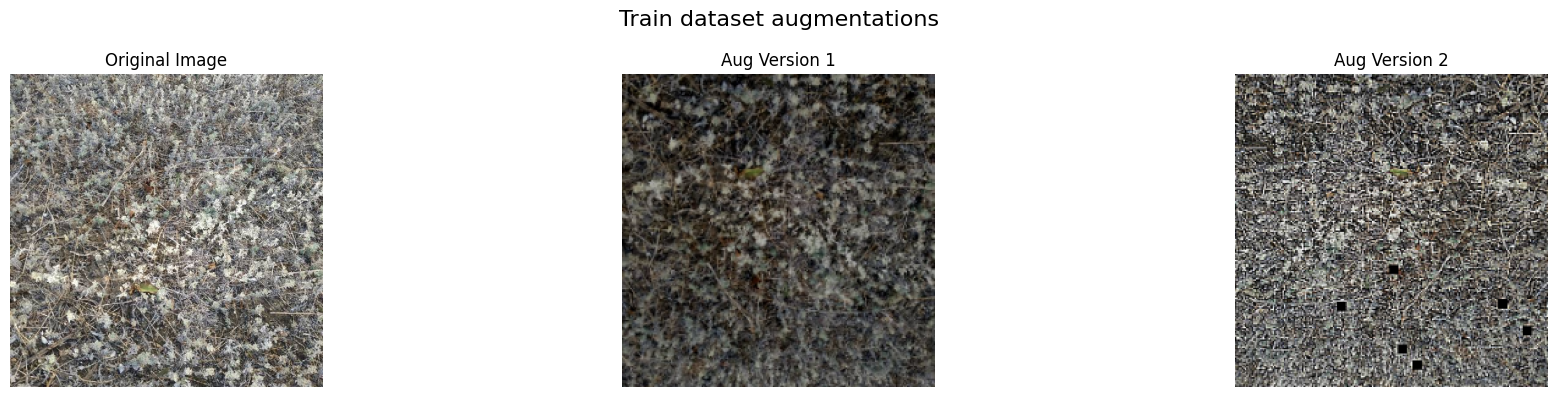

Feature                       Original       Aug Version 1  Aug Version 2  
WORLDCLIM_BI...               11.37          11.37          11.37          
WORLDCLIM_BI...               414.74         414.74         414.74         
WORLDCLIM_BI...               29.26          29.26          29.26          
WORLDCLIM_BI...               22.83          22.83          22.83          
WORLDCLIM_BI...               807.79         807.79         807.79         


In [33]:
visualize_augmentations(dataset=train_dataset, title='Train dataset augmentations', idx=14, augment_times=2)

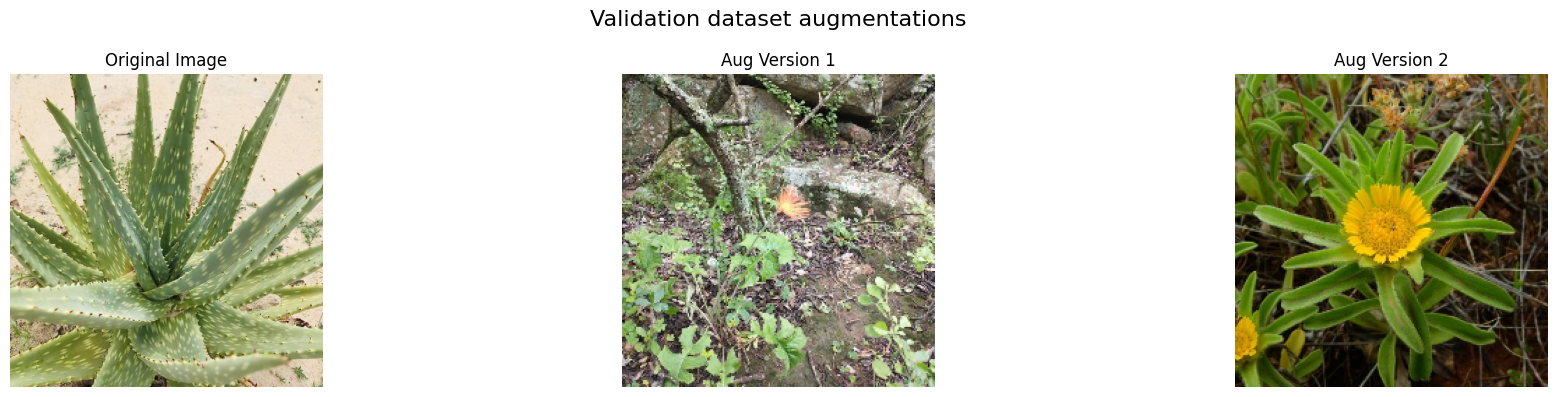

Feature                       Original       Aug Version 1  Aug Version 2  
WORLDCLIM_BI...               22.97          15.67          15.32          
WORLDCLIM_BI...               520.93         1140.20        327.54         
WORLDCLIM_BI...               125.90         192.40         38.06          
WORLDCLIM_BI...               113.79         77.63          49.06          
WORLDCLIM_BI...               343.12         296.41         625.87         


In [34]:
visualize_augmentations(dataset=val_dataset, title='Validation dataset augmentations', idx=14, augment_times=2)

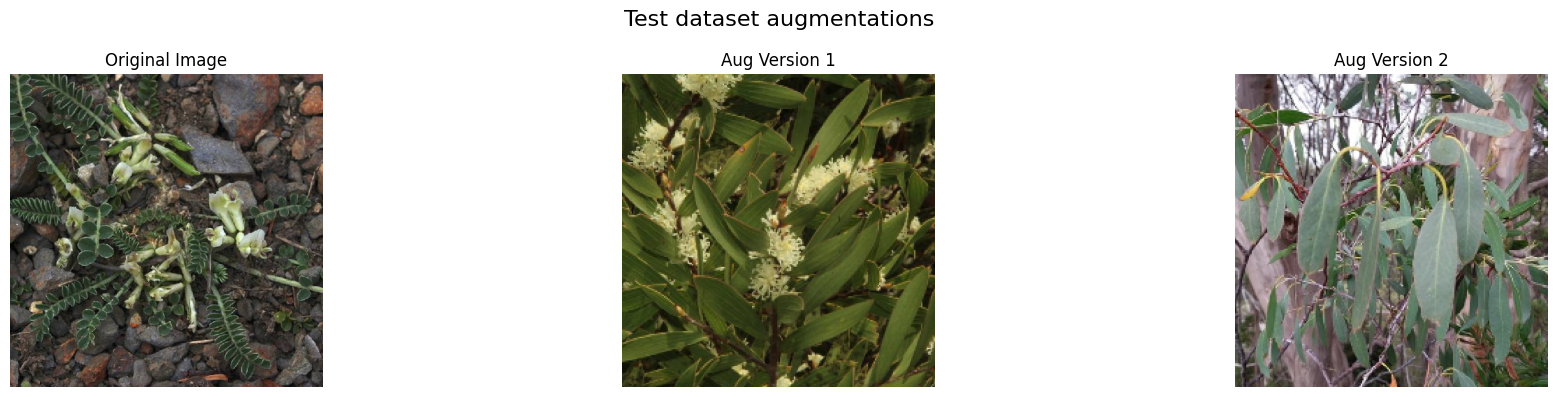

Feature                       Original       Aug Version 1  Aug Version 2  
WORLDCLIM_BI...               3.11           12.70          5.96           
WORLDCLIM_BI...               1440.20        644.07         1566.17        
WORLDCLIM_BI...               95.53          64.13          89.85          
WORLDCLIM_BI...               24.42          43.71          22.09          
WORLDCLIM_BI...               627.31         351.10         332.18         


In [35]:
visualize_augmentations(dataset=test_dataset, title='Test dataset augmentations', idx=14, augment_times=2)

#**Baselines**

In [36]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms, models
from torch.utils.data import DataLoader

## Create dataloaders


In [94]:
train_loader = DataLoader(train_dataset, batch_size= 16, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size = 16, shuffle = False)
test_loader = DataLoader(test_dataset, batch_size= 16, shuffle=False)

In [38]:
class PlantTraitsPretrainedEfficientNet(nn.Module):
    def __init__(self):
        super().__init__()

        # Load a pre-trained EfficientNetB0 as the base model and remove the classifier
        #self.model = models.efficientnet_v2_s(weights=models.EfficientNet_V2_S_Weights)
        self.model = models.efficientnet_b0(pretrained=True)
        self.model.classifier = nn.Identity()
        self.fc = nn.Linear(1280, 6)  # 1280 is the number of features before the classifier in EfficientNetB0

    def forward(self, x):
        x = self.model(x)
        x = self.fc(x)
        return x

In [39]:
class PlantTraitsPretrainedVGG16(nn.Module):
    def __init__(self):
        super().__init__()

        self.network = models.vgg16(pretrained=True)
        # Replace last layer
        self.network.classifier = nn.Sequential(
           nn.Linear(in_features=25088, out_features=4096, bias=True),
           nn.ReLU(inplace=True),
           nn.Dropout(p=0.3, inplace=False),
           nn.Linear(in_features=4096, out_features=2048, bias=True),
           nn.ReLU(inplace=True),
           nn.Dropout(p=0.3, inplace=False),
           nn.Linear(in_features=2048, out_features=6, bias=True),
        )

    def forward(self, xb):
        return self.network(xb)

In [40]:
class PlantTraitsPretrainedResNet(nn.Module):
    def __init__(self):
        super().__init__()

        self.network = models.resnet50(pretrained=True)
        # Replace last layer
        self.network.classifier = nn.Sequential(
           nn.Linear(in_features=self.network.fc.in_features, out_features=6, bias=True)
        )

    def forward(self, xb):
        return self.network(xb)

In [41]:
models.vit_b_16(pretrained=True)

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ViT_B_16_Weights.IMAGENET1K_V1`. You can also use `weights=ViT_B_16_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/vit_b_16-c867db91.pth" to /root/.cache/torch/hub/checkpoints/vit_b_16-c867db91.pth
100%|██████████| 330M/330M [00:02<00:00, 121MB/s]


VisionTransformer(
  (conv_proj): Conv2d(3, 768, kernel_size=(16, 16), stride=(16, 16))
  (encoder): Encoder(
    (dropout): Dropout(p=0.0, inplace=False)
    (layers): Sequential(
      (encoder_layer_0): EncoderBlock(
        (ln_1): LayerNorm((768,), eps=1e-06, elementwise_affine=True)
        (self_attention): MultiheadAttention(
          (out_proj): NonDynamicallyQuantizableLinear(in_features=768, out_features=768, bias=True)
        )
        (dropout): Dropout(p=0.0, inplace=False)
        (ln_2): LayerNorm((768,), eps=1e-06, elementwise_affine=True)
        (mlp): MLPBlock(
          (0): Linear(in_features=768, out_features=3072, bias=True)
          (1): GELU(approximate='none')
          (2): Dropout(p=0.0, inplace=False)
          (3): Linear(in_features=3072, out_features=768, bias=True)
          (4): Dropout(p=0.0, inplace=False)
        )
      )
      (encoder_layer_1): EncoderBlock(
        (ln_1): LayerNorm((768,), eps=1e-06, elementwise_affine=True)
        (self_a

In [42]:
class PlantTraitsPretrainedVisionTransformer(nn.Module):
  def __init__(self):
    super().__init__()
    self.network = models.vit_b_16(pretrained=True)

    self.network.heads.head = nn.Linear(self.network.heads.head.in_features, 6, bias=True)

  def forward(self, xb):
    return self.network(xb)

In [43]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model = PlantTraitsPretrainedVisionTransformer()
model = model.to(device)
model

PlantTraitsPretrainedVisionTransformer(
  (network): VisionTransformer(
    (conv_proj): Conv2d(3, 768, kernel_size=(16, 16), stride=(16, 16))
    (encoder): Encoder(
      (dropout): Dropout(p=0.0, inplace=False)
      (layers): Sequential(
        (encoder_layer_0): EncoderBlock(
          (ln_1): LayerNorm((768,), eps=1e-06, elementwise_affine=True)
          (self_attention): MultiheadAttention(
            (out_proj): NonDynamicallyQuantizableLinear(in_features=768, out_features=768, bias=True)
          )
          (dropout): Dropout(p=0.0, inplace=False)
          (ln_2): LayerNorm((768,), eps=1e-06, elementwise_affine=True)
          (mlp): MLPBlock(
            (0): Linear(in_features=768, out_features=3072, bias=True)
            (1): GELU(approximate='none')
            (2): Dropout(p=0.0, inplace=False)
            (3): Linear(in_features=3072, out_features=768, bias=True)
            (4): Dropout(p=0.0, inplace=False)
          )
        )
        (encoder_layer_1): Encode

In [44]:
model

PlantTraitsPretrainedVisionTransformer(
  (network): VisionTransformer(
    (conv_proj): Conv2d(3, 768, kernel_size=(16, 16), stride=(16, 16))
    (encoder): Encoder(
      (dropout): Dropout(p=0.0, inplace=False)
      (layers): Sequential(
        (encoder_layer_0): EncoderBlock(
          (ln_1): LayerNorm((768,), eps=1e-06, elementwise_affine=True)
          (self_attention): MultiheadAttention(
            (out_proj): NonDynamicallyQuantizableLinear(in_features=768, out_features=768, bias=True)
          )
          (dropout): Dropout(p=0.0, inplace=False)
          (ln_2): LayerNorm((768,), eps=1e-06, elementwise_affine=True)
          (mlp): MLPBlock(
            (0): Linear(in_features=768, out_features=3072, bias=True)
            (1): GELU(approximate='none')
            (2): Dropout(p=0.0, inplace=False)
            (3): Linear(in_features=3072, out_features=768, bias=True)
            (4): Dropout(p=0.0, inplace=False)
          )
        )
        (encoder_layer_1): Encode

In [45]:
!pip -q install torchmetrics

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 841.5/841.5 kB 4.9 MB/s eta 0:00:00


In [46]:
from torchmetrics.regression import R2Score

In [47]:
def r2_loss(output, target):
    target = target
    output = output
    target_mean = torch.mean(target)
    ss_tot = torch.sum((target - target_mean) ** 2)
    ss_res = torch.sum((target - output) ** 2)
    r2 = 1 - ss_res / ss_tot
    return 1 - r2

In [95]:
#Adatok GPU-ra való átmásolását végző függvény
def to_device(data, device):
  if isinstance(data, (list, tuple)):
    return [to_device(x, device) for x in data]
  return data.to(device, non_blocking=True)

In [49]:
class DeviceDataLoader():
  def __init__(self, dl, device):
    self.dl = dl
    self.device = device

  def __iter__(self):
    for b in self.dl:
      yield to_device(b, self.device)

  def __len__(self):
    return len(self.dl)

In [96]:
train_loader = DeviceDataLoader(train_loader, device)
val_loader = DeviceDataLoader(val_loader, device)
test_loader = DeviceDataLoader(test_loader, device)

In [51]:
from tqdm.notebook import tqdm #a progress bár esztétikus megjelenítésére

In [52]:
def save_checkpoint(state, filename="/content/model_checkpoint.pth.tar"):
    torch.save(state, filename)
    print(f"Checkpoint saved to {filename}")

def load_checkpoint(checkpoint_file, model, optimizer, scheduler, device):
    checkpoint = torch.load(checkpoint_file, map_location=device)
    model.load_state_dict(checkpoint['model_state_dict'])
    optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
    scheduler.load_state_dict(checkpoint['scheduler_state_dict'])
    return checkpoint['epoch']

In [ ]:
class EarlyStoppingR2:
    def __init__(self, patience=10, delta=0, save=None):
        self.patience = patience
        self.counter = 0
        self.best_score = None
        self.early_stop = False
        self.delta = delta
        self.save = save

    def __call__(self, val_score, epoch, model, optimizer, scheduler):
        if self.best_score is None:
            self.best_score = val_score
            print(f"Best model loss: {val_score}")
            if self.save:
                checkpoint_filename = '/content/best_model.pth.tar'
                self.save({
                    'epoch': epoch + 1,
                    'model_state_dict': model.state_dict(),
                    'optimizer_state_dict': optimizer.state_dict(),
                    'scheduler_state_dict': scheduler.state_dict(),
                }, filename=checkpoint_filename)
        elif val_score < self.best_score - self.delta:
            self.counter += 1
            print(f"EarlyStopping patience counter: {self.counter}")
            if self.counter >= self.patience:
                self.early_stop = True
        else:
            if val_score > self.best_score:
                self.best_score = val_score
                self.counter = 0
                print(f"Best model loss: {val_score}")
                if self.save:
                    checkpoint_filename = '/content/best_model.pth.tar'
                    self.save({
                        'epoch': epoch + 1,
                        'model_state_dict': model.state_dict(),
                        'optimizer_state_dict': optimizer.state_dict(),
                        'scheduler_state_dict': scheduler.state_dict(),
                    }, filename=checkpoint_filename)

In [ ]:
def get_lr(optimizer):
    for param_group in optimizer.param_groups:
        return param_group['lr']

def train(model, train_loader, val_loader, criterion, max_lr, grad_clip=0, opt_func=torch.optim.Adam,  weight_decay=0, epochs=10,
          architecture_name= "CNN", dataset_ratio = 0.1, resume = False, checkpoint_path='/content/best_model.pth.tar', experiment_name="exp"):
    torch.cuda.empty_cache()
    optimizer = opt_func(model.parameters(), max_lr, weight_decay=weight_decay)
    r2_score_metrics = R2Score(num_outputs=6).to(device)
     # set up one cycle lr scheduler
    sched = torch.optim.lr_scheduler.OneCycleLR(optimizer, max_lr, epochs=epochs,  steps_per_epoch=len(train_loader))
    early_stopping = EarlyStoppingR2(patience=3, save=save_checkpoint)

    wandb.init(
      # Set the project where this run will be logged
      project="Plant_traits",
      # We pass a run name (otherwise it’ll be randomly assigned, like sunshine-lollypop-10)
      name=experiment_name,
      # Track hyperparameters and run metadata
      config={
        "max_learning_rate": max_lr,
        "architecture": architecture_name,
        "epochs": epochs,
        "dataset_ratio" : dataset_ratio,
        "criterion" : criterion,
        "grad_clip" : grad_clip,
        "opt_func" : opt_func
      })

    start_epoch = 0
    if resume and checkpoint_path:
        start_epoch = load_checkpoint(checkpoint_path, model, optimizer, sched, device)

    best_loss = float('inf')
    for epoch in range(start_epoch, start_epoch + epochs):
        model.train()
        epoch_loss = 0
        lrs = []
        for images, meta_data, targets in tqdm(train_loader):


            outputs = model(images)
            loss = criterion(outputs, targets)
            loss.backward()
            if grad_clip:
               nn.utils.clip_grad_value_(model.parameters(), grad_clip)
            optimizer.step()
            optimizer.zero_grad()
            epoch_loss += loss.item() * images.size(0)
            lrs.append(get_lr(optimizer))
            sched.step()

        epoch_loss = epoch_loss / len(train_loader)
        print(f'Epoch {epoch+1}, Loss: {epoch_loss}')

        model.eval()  # Set model to evaluation mode

        with torch.no_grad():
            epoch_val_loss = 0.0
            r2_epoch_score = 0.0
            for images, meta_data, targets in tqdm(val_loader):

                outputs = model(images)
                loss = criterion(outputs, targets)
                epoch_val_loss += loss.item() * images.size(0)
                r2_epoch_score += r2_score_metrics(outputs, targets)

            epoch_val_loss = epoch_val_loss /len(val_loader)
            r2_score = r2_epoch_score / len(val_loader)


            print(f'Epoch {epoch + 1}/{epochs} Validation Loss: {epoch_val_loss:.4f}')
            print(f'Validation R2 Score: {r2_score}')
            wandb.log({"val_loss": epoch_val_loss, "loss": epoch_loss, "r2_score": r2_score})
            early_stopping(r2_score, epoch, model, optimizer, sched)
            if early_stopping.early_stop:
                print("Early stopping triggered.")
                break

    # Mark the run as finished
    wandb.finish()

def test_model(model, criterion, test_loader):
    model.eval()  # Set model to evaluation mode
    epoch_loss = 0.0
    r2_score_metrics = R2Score(num_outputs=6).to(device)
    r2_epoch_score = 0
    with torch.no_grad():
       for images, meta_data, targets in test_loader:
            outputs = model(images)
            loss = criterion(outputs, targets)
            epoch_loss += loss.item() * images.size(0)
            r2_epoch_score += r2_score_metrics(outputs, targets)

    test_loss = epoch_loss / len(test_loader)
    r2_score = r2_epoch_score / len(val_loader)
    print(f'Test Loss: {test_loss:.4f}')
    print(f'Validation R2 Score: {r2_score}')



Train a
- ResNet (too slow)
- VGG
- Efficientnet

In [53]:
epochs = 10
opt_func = torch.optim.SGD
loss_func =r2_loss #  nn.MSELoss()
max_lr = 0.01
grad_clip = 0
weight_decay = 1e-6
dataset_ratio = 0.1
architecture_name = "CNN - EfficientNetB0 - None"

In [ ]:
wandb.finish()

In [ ]:
train(model, train_loader, val_loader, criterion = loss_func, max_lr = max_lr, grad_clip=0, opt_func=opt_func, weight_decay= weight_decay, epochs=epochs,
      architecture_name= architecture_name,dataset_ratio = dataset_ratio, experiment_name = "ViT - None" )

  0%|          | 0/833 [00:00<?, ?it/s]

Epoch 1, Loss: 3.551222565723639


  0%|          | 0/70 [00:00<?, ?it/s]

Epoch 1/10 Validation Loss: 2.9688
Validation R2 Score: -0.020987868309020996
Best model loss: -0.020987868309020996
Checkpoint saved to /content/best_model.pth.tar


  0%|          | 0/833 [00:00<?, ?it/s]

Epoch 2, Loss: 2.792945068280379


  0%|          | 0/70 [00:00<?, ?it/s]

Epoch 2/10 Validation Loss: 3.0112
Validation R2 Score: 0.0716974139213562
Best model loss: 0.0716974139213562
Checkpoint saved to /content/best_model.pth.tar


  0%|          | 0/833 [00:00<?, ?it/s]

KeyboardInterrupt: 

In [ ]:
train(model, train_loader, val_loader, criterion = loss_func, max_lr = max_lr, grad_clip=0, opt_func=opt_func, weight_decay= weight_decay, epochs=5,
      architecture_name= architecture_name,dataset_ratio = dataset_ratio, resume=True)

In [ ]:
test_model(model, r2_loss, val_loader)

Test Loss: 3.4380
Validation R2 Score: -0.08563786000013351


In [ ]:
from enum import Enum

class AugmentationsComplexity(Enum):
  NONE = {
      "augmentation" : None,
      "augmentation_times" : 1,
  }
  SMALL = {
      "augmentation" : A.Compose([
          A.HorizontalFlip(p=0.5),
          A.VerticalFlip(p=0.5),
          A.Rotate(limit=45, p=0.5),
          A.RandomResizedCrop(height=256, width=256, scale=(0.8, 1.0), p=0.5),
          A.RandomBrightnessContrast(brightness_limit=0.2, contrast_limit=0.2, p=0.5),
          A.CoarseDropout(max_holes=8, max_height=8, max_width=8, min_holes=2, fill_value=0, p=0.5),
          A.Sharpen(alpha=0.3, lightness=0.3, p=0.5),
          A.Resize(256, 256)
        ]),
      "augmentation_times" : 3,
  }
  LARGE = {
      "augmentation" : A.Compose([
          A.HorizontalFlip(p=0.5),
          A.VerticalFlip(p=0.5),
          A.Rotate(limit=45, p=0.5),
          A.RandomResizedCrop(height=256, width=256, scale=(0.8, 1.0), p=0.5),
          A.RandomBrightnessContrast(brightness_limit=0.2, contrast_limit=0.2, p=0.5),
          A.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.02, p=0.2),
          A.ElasticTransform(alpha=1, sigma=15, alpha_affine=15, p=0.2),
          A.GaussianBlur(blur_limit=3, p=0.5),
          A.CLAHE(clip_limit=4.0, tile_grid_size=(8, 8), p=0.5),
          A.CoarseDropout(max_holes=8, max_height=8, max_width=8, min_holes=2, fill_value=0, p=0.5),
          A.Sharpen(alpha=0.3, lightness=0.3, p=0.5),
          A.RandomShadow(shadow_roi=(0, 0.5, 1, 1), num_shadows_lower=1, num_shadows_upper=3, shadow_dimension=50, p=0.5),
          A.Resize(256, 256)
        ]),
      "augmentation_times" : 3,
  }

/usr/local/lib/python3.10/dist-packages/albumentations/augmentations/blur/transforms.py:184: UserWarning: blur_limit and sigma_limit minimum value can not be both equal to 0. blur_limit minimum value changed to 3.
  warnings.warn(


In [ ]:
from enum import Enum

class AugmentationsComplexity(Enum):
  NONE = {
      "augmentation" : None,
      "augmentation_times" : 1,
  }
  SMALL = {
      "augmentation" : A.Compose([
          A.HorizontalFlip(p=0.5),
          A.VerticalFlip(p=0.5),
          A.Rotate(limit=45, p=0.5),
          A.RandomResizedCrop(height=256, width=256, scale=(0.8, 1.0), p=0.5),
          A.RandomBrightnessContrast(brightness_limit=0.2, contrast_limit=0.2, p=0.5),
          A.CoarseDropout(max_holes=8, max_height=8, max_width=8, min_holes=2, fill_value=0, p=0.5),
          A.Sharpen(alpha=0.3, lightness=0.3, p=0.5),
          A.Resize(256, 256)
        ]),
      "augmentation_times" : 3,
  }
  LARGE = {
      "augmentation" : A.Compose([
          A.HorizontalFlip(p=0.5),
          A.VerticalFlip(p=0.5),
          A.Rotate(limit=45, p=0.5),
          A.RandomResizedCrop(height=256, width=256, scale=(0.8, 1.0), p=0.5),
          A.RandomBrightnessContrast(brightness_limit=0.2, contrast_limit=0.2, p=0.5),
          A.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.02, p=0.2),
          A.ElasticTransform(alpha=1, sigma=15, alpha_affine=15, p=0.2),
          A.GaussianBlur(blur_limit=3, p=0.5),
          A.CLAHE(clip_limit=4.0, tile_grid_size=(8, 8), p=0.5),
          A.CoarseDropout(max_holes=8, max_height=8, max_width=8, min_holes=2, fill_value=0, p=0.5),
          A.Sharpen(alpha=0.3, lightness=0.3, p=0.5),
          A.RandomShadow(shadow_roi=(0, 0.5, 1, 1), num_shadows_lower=1, num_shadows_upper=3, shadow_dimension=50, p=0.5),
          A.Resize(256, 256)
        ]),
      "augmentation_times" : 3,
  }

In [ ]:
checkpoint_path = '/content/best_efficientnetv2'
experiment_name =  'efficientNetv2'

In [ ]:
def train_with_different_augmentations():
  for complexity in [AugmentationsComplexity.NONE,AugmentationsComplexity.SMALL,AugmentationsComplexity.LARGE]:
    train_dataset, val_dataset, test_dataset = create_dataset(train_df, test_df, metadata_columns, targets, TRAIN_IMAGES_PATH, TEST_IMAGES_PATH, augment_times=complexity.value["augmentation_times"], train_augmentation=complexity.value["augmentation"])
    print(len(train_dataset), len(val_dataset), len(test_dataset))
    train_loader = DataLoader(train_dataset, batch_size= 16, shuffle=True)
    val_loader = DataLoader(val_dataset, batch_size = 16, shuffle = False)
    test_loader = DataLoader(test_dataset, batch_size= 16, shuffle=False)
    train_loader = DeviceDataLoader(train_loader, device)
    val_loader = DeviceDataLoader(val_loader, device)
    test_loader = DeviceDataLoader(test_loader, device)

    train(model, train_loader, val_loader, criterion = loss_func, max_lr = max_lr, grad_clip=grad_clip, opt_func=opt_func, weight_decay=weight_decay, epochs=10,
        architecture_name="EfficientNet", dataset_ratio = dataset_ratio, resume=False, checkpoint_path=f'{checkpoint_path}_{complexity.name}.pth.tar', experiment_name=f'{experiment_name}_{complexity.name}')

In [ ]:
train_with_different_augmentations()

4439 1110 654


  0%|          | 0/278 [00:00<?, ?it/s]

Epoch 1, Loss: 0.8874565026314138


  0%|          | 0/70 [00:00<?, ?it/s]

Epoch 1/10 Validation Loss: 3.2838
Validation R2 Score: -0.0012941871536895633
Best model loss: -0.0012941871536895633
Checkpoint saved to /content/best_model.pth.tar


  0%|          | 0/278 [00:00<?, ?it/s]

Epoch 2, Loss: 0.846309533007711


  0%|          | 0/70 [00:00<?, ?it/s]

Epoch 2/10 Validation Loss: 3.2955
Validation R2 Score: -0.0009526261128485203
Best model loss: -0.0009526261128485203
Checkpoint saved to /content/best_model.pth.tar


  0%|          | 0/278 [00:00<?, ?it/s]

Epoch 3, Loss: 0.7971308244218072


  0%|          | 0/70 [00:00<?, ?it/s]

Epoch 3/10 Validation Loss: 3.2705
Validation R2 Score: -0.007576244417577982
EarlyStopping patience counter: 1


  0%|          | 0/278 [00:00<?, ?it/s]

Epoch 4, Loss: 0.7638348967051335


  0%|          | 0/70 [00:00<?, ?it/s]

Epoch 4/10 Validation Loss: 3.2900
Validation R2 Score: -0.012479506433010101
EarlyStopping patience counter: 2


  0%|          | 0/278 [00:00<?, ?it/s]

Epoch 5, Loss: 0.7057766820029389


  0%|          | 0/70 [00:00<?, ?it/s]

Epoch 5/10 Validation Loss: 3.3164
Validation R2 Score: -0.03456190228462219
EarlyStopping patience counter: 3
Early stopping triggered.


loss,█▆▅▃▁
r2_score,██▇▆▁
val_loss,▃▅▁▄█
loss,0.70578
r2_score,-0.03456
val_loss,3.31642


13317 1110 654


  0%|          | 0/833 [00:00<?, ?it/s]

Epoch 1, Loss: 1.0142241682754416


  0%|          | 0/70 [00:00<?, ?it/s]

Epoch 1/10 Validation Loss: 3.3541
Validation R2 Score: -0.029557576403021812
Best model loss: -0.029557576403021812
Checkpoint saved to /content/best_model.pth.tar


  0%|          | 0/833 [00:00<?, ?it/s]

Epoch 2, Loss: 1.0022939378473938


  0%|          | 0/70 [00:00<?, ?it/s]

Epoch 2/10 Validation Loss: 3.3562
Validation R2 Score: -0.0427069365978241
EarlyStopping patience counter: 1


  0%|          | 0/833 [00:00<?, ?it/s]

Epoch 3, Loss: 0.9723115058935562


  0%|          | 0/70 [00:00<?, ?it/s]

Epoch 3/10 Validation Loss: 3.3460
Validation R2 Score: -0.023641683161258698
Best model loss: -0.023641683161258698
Checkpoint saved to /content/best_model.pth.tar


  0%|          | 0/833 [00:00<?, ?it/s]

Epoch 4, Loss: 0.9342306451637203


  0%|          | 0/70 [00:00<?, ?it/s]

Epoch 4/10 Validation Loss: 3.3734
Validation R2 Score: -0.0505334734916687
EarlyStopping patience counter: 1


  0%|          | 0/833 [00:00<?, ?it/s]

Epoch 5, Loss: 0.8976131993181565


  0%|          | 0/70 [00:00<?, ?it/s]

Epoch 5/10 Validation Loss: 3.3749
Validation R2 Score: -0.0601595863699913
EarlyStopping patience counter: 2


  0%|          | 0/833 [00:00<?, ?it/s]

Epoch 6, Loss: 0.8587866540716476


  0%|          | 0/70 [00:00<?, ?it/s]

Epoch 6/10 Validation Loss: 3.2724
Validation R2 Score: -0.012668048031628132
Best model loss: -0.012668048031628132
Checkpoint saved to /content/best_model.pth.tar


  0%|          | 0/833 [00:00<?, ?it/s]

Epoch 7, Loss: 0.8281095087313566


  0%|          | 0/70 [00:00<?, ?it/s]

Epoch 7/10 Validation Loss: 3.3292
Validation R2 Score: -0.04515158385038376
EarlyStopping patience counter: 1


  0%|          | 0/833 [00:00<?, ?it/s]

Epoch 8, Loss: 0.7959193642399892


  0%|          | 0/70 [00:00<?, ?it/s]

Epoch 8/10 Validation Loss: 3.3220
Validation R2 Score: -0.0377257764339447
EarlyStopping patience counter: 2


  0%|          | 0/833 [00:00<?, ?it/s]

Epoch 9, Loss: 0.7590036807226247


  0%|          | 0/70 [00:00<?, ?it/s]

Epoch 9/10 Validation Loss: 3.3349
Validation R2 Score: -0.049152545630931854
EarlyStopping patience counter: 3
Early stopping triggered.


loss,██▇▆▅▄▃▂▁
r2_score,▆▄▆▂▁█▃▄▃
val_loss,▇▇▆██▁▅▄▅
loss,0.759
r2_score,-0.04915
val_loss,3.33488


13317 1110 654


  0%|          | 0/833 [00:00<?, ?it/s]

Epoch 1, Loss: 1.0435225150736869


  0%|          | 0/70 [00:00<?, ?it/s]

Epoch 1/10 Validation Loss: 3.3697
Validation R2 Score: -0.04396742582321167
Best model loss: -0.04396742582321167
Checkpoint saved to /content/best_model.pth.tar


  0%|          | 0/833 [00:00<?, ?it/s]

Epoch 2, Loss: 1.0367412844053407


  0%|          | 0/70 [00:00<?, ?it/s]

Epoch 2/10 Validation Loss: 3.3930
Validation R2 Score: -0.04787681996822357
EarlyStopping patience counter: 1


  0%|          | 0/833 [00:00<?, ?it/s]

Epoch 3, Loss: 1.0351927485071024


  0%|          | 0/70 [00:00<?, ?it/s]

Epoch 3/10 Validation Loss: 3.3680
Validation R2 Score: -0.04853621870279312
EarlyStopping patience counter: 2


  0%|          | 0/833 [00:00<?, ?it/s]

Epoch 4, Loss: 1.0111357641964256


  0%|          | 0/70 [00:00<?, ?it/s]

Epoch 4/10 Validation Loss: 3.3492
Validation R2 Score: -0.03220708668231964
Best model loss: -0.03220708668231964
Checkpoint saved to /content/best_model.pth.tar


  0%|          | 0/833 [00:00<?, ?it/s]

Epoch 5, Loss: 0.9598073235222129


  0%|          | 0/70 [00:00<?, ?it/s]

Epoch 5/10 Validation Loss: 3.3829
Validation R2 Score: -0.05625544488430023
EarlyStopping patience counter: 1


  0%|          | 0/833 [00:00<?, ?it/s]

# Hyperopt

In [ ]:
def train(model, train_loader, val_loader, criterion, max_lr, optimizer, grad_clip=0, weight_decay=0, epochs=10,
          architecture_name="CNN", dataset_ratio=0.1, resume=False, checkpoint_path='/content/best_model.pth.tar', experiment_name="exp", trial=None):
    device = 'cuda' if torch.cuda.is_available() else 'cpu'
    model.to(device)
    torch.cuda.empty_cache()
    optimizer = opt_func(model.parameters())
    r2_score_metrics = R2Score(num_outputs=6).to(device)
    sched = OneCycleLR(optimizer, max_lr, epochs=epochs, steps_per_epoch=len(train_loader))

    wandb.init(
        project="Plant_traits",
        name=experiment_name,
        config={
            "max_learning_rate": max_lr,
            "architecture": architecture_name,
            "epochs": epochs,
            "dataset_ratio": dataset_ratio,
            "criterion": criterion,
            "grad_clip": grad_clip,
            "optimizer": opt_func.__name__
        }
    )

    start_epoch = 0
    if resume and checkpoint_path:
        start_epoch = load_checkpoint(checkpoint_path, model, sched, device, optimizer)

    best_loss = float('inf')
    for epoch in range(start_epoch, epochs):
        model.train()
        total_loss = 0
        lrs = []

        for images, meta_data, targets in tqdm(train_loader):
            images, targets = images.to(device), targets.to(device)

            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, targets)
            loss.backward()
            if grad_clip:
                torch.nn.utils.clip_grad_value_(model.parameters(), grad_clip)
            optimizer.step()
            sched.step()

            total_loss += loss.item() * images.size(0)
            lrs.append(get_lr(optimizer))

        epoch_loss = total_loss / len(train_loader)
        wandb.log({"epoch": epoch + 1, "loss": epoch_loss, "lr": lrs[-1]})

        model.eval()
        epoch_val_loss, r2_epoch_score = 0.0, 0.0
        with torch.no_grad():
            for images, meta_data, targets in tqdm(val_loader):
                images, targets = images.to(device), targets.to(device)
                outputs = model(images)
                loss = criterion(outputs, targets)
                epoch_val_loss += loss.item() * images.size(0)
                r2_epoch_score += r2_score_metrics(outputs, targets)

        epoch_val_loss /= len(val_loader)
        r2_score = r2_epoch_score / len(val_loader)

        wandb.log({"val_loss": epoch_val_loss, "loss": epoch_loss, "r2_score": r2_score})
        print(f'Epoch {epoch + 1}/{epochs} Validation Loss: {epoch_val_loss:.4f}')
        print(f'Validation R2 Score: {r2_score}')

        if trial:
            trial.report(epoch_val_loss, epoch)
            if trial.should_prune():
                raise optuna.TrialPruned()

    wandb.finish()
    return epoch_val_loss

In [ ]:
def objective(trial):
    max_lr = trial.suggest_float('max_lr', 1e-5, 1e-1)

    optimizer_choices = {'Adam': optim.Adam, 'RMSprop': optim.RMSprop, 'SGD': optim.SGD}
    optimizer_name = trial.suggest_categorical('optimizer', list(optimizer_choices.keys()))
    optimizer_class = optimizer_choices[optimizer_name]

    weight_decay = trial.suggest_float('weight_decay', 1e-10, 1e-3)
    grad_clip = trial.suggest_float('grad_clip', 0, 1.0)

    if optimizer_name == 'SGD':
        momentum = trial.suggest_float('momentum', 0.0, 1.0)
        optimizer = lambda params: optimizer_choices[optimizer_name](params, lr=max_lr, momentum=momentum, weight_decay=weight_decay)
    else:
        optimizer = lambda params: optimizer_choices[optimizer_name](params, lr=max_lr, weight_decay=weight_decay)


    model = PlantTraitsPretrainedVisionTransformer()
    model = model.to(device)

    return train(model, train_loader, val_loader, r2_loss, max_lr, optimizer, grad_clip, weight_decay, epochs = 5, trial=trial, experiment_name='ViT - hyperopt')

study = optuna.create_study(direction='minimize', pruner=optuna.pruners.MedianPruner())
study.optimize(objective, n_trials=5)

print("Best trial:")
trial = study.best_trial
print(f"  Value: {trial.value}")
print("  Params: ")
for key, value in trial.params.items():
    print(f"    {key}: {value}")

[I 2024-04-15 20:27:17,118] A new study created in memory with name: no-name-e7167d73-3644-4b4a-8c81-296cfe32535b
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ViT_B_16_Weights.IMAGENET1K_V1`. You can also use `weights=ViT_B_16_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


epoch,▁▁
loss,▁
lr,▁
val_loss,▁
val_r2_score,▁
epoch,1
loss,5.0091
lr,0.00074
val_loss,3.027
val_r2_score,-0.1183


  0%|          | 0/555 [00:00<?, ?it/s]

[W 2024-04-15 20:30:35,441] Trial 0 failed with parameters: {'max_lr': 0.05121048303347446, 'optimizer': 'RMSprop', 'weight_decay': 0.0002016477037654076, 'grad_clip': 0.6765899608421828} because of the following error: KeyboardInterrupt().
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/optuna/study/_optimize.py", line 196, in _run_trial
    value_or_values = func(trial)
  File "<ipython-input-120-a604fd930962>", line 21, in objective
    return train(model, train_loader, val_loader, r2_loss, max_lr, optimizer, grad_clip, weight_decay, epochs = 3, trial=trial, experiment_name='ViT - hyperopt')
  File "<ipython-input-119-257c2edc9fa2>", line 40, in train
    loss.backward()
  File "/usr/local/lib/python3.10/dist-packages/torch/_tensor.py", line 522, in backward
    torch.autograd.backward(
  File "/usr/local/lib/python3.10/dist-packages/torch/autograd/__init__.py", line 266, in backward
    Variable._execution_engine.run_backward(  # Calls into the C+

KeyboardInterrupt: 

# Inference

In [59]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [60]:
checkpoint_path = '/content/drive/MyDrive/best_model.pth.tar'

In [116]:
model = PlantTraitsPretrainedVGG16()

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG16_Weights.IMAGENET1K_V1`. You can also use `weights=VGG16_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/vgg16-397923af.pth" to /root/.cache/torch/hub/checkpoints/vgg16-397923af.pth
100%|██████████| 528M/528M [00:07<00:00, 69.3MB/s]


In [117]:
optimizer = opt_func(model.parameters(), max_lr, weight_decay=weight_decay)
sched = OneCycleLR(optimizer, max_lr, epochs=epochs, steps_per_epoch=len(test_loader))
load_checkpoint(checkpoint_path, model, optimizer, sched, device)

RuntimeError: Error(s) in loading state_dict for PlantTraitsPretrainedVGG16:
	Missing key(s) in state_dict: "network.features.0.weight", "network.features.0.bias", "network.features.2.weight", "network.features.2.bias", "network.features.5.weight", "network.features.5.bias", "network.features.7.weight", "network.features.7.bias", "network.features.10.weight", "network.features.10.bias", "network.features.12.weight", "network.features.12.bias", "network.features.14.weight", "network.features.14.bias", "network.features.17.weight", "network.features.17.bias", "network.features.19.weight", "network.features.19.bias", "network.features.21.weight", "network.features.21.bias", "network.features.24.weight", "network.features.24.bias", "network.features.26.weight", "network.features.26.bias", "network.features.28.weight", "network.features.28.bias", "network.classifier.0.weight", "network.classifier.0.bias", "network.classifier.3.weight", "network.classifier.3.bias", "network.classifier.6.weight", "network.classifier.6.bias". 
	Unexpected key(s) in state_dict: "network.class_token", "network.conv_proj.weight", "network.conv_proj.bias", "network.encoder.pos_embedding", "network.encoder.layers.encoder_layer_0.ln_1.weight", "network.encoder.layers.encoder_layer_0.ln_1.bias", "network.encoder.layers.encoder_layer_0.self_attention.in_proj_weight", "network.encoder.layers.encoder_layer_0.self_attention.in_proj_bias", "network.encoder.layers.encoder_layer_0.self_attention.out_proj.weight", "network.encoder.layers.encoder_layer_0.self_attention.out_proj.bias", "network.encoder.layers.encoder_layer_0.ln_2.weight", "network.encoder.layers.encoder_layer_0.ln_2.bias", "network.encoder.layers.encoder_layer_0.mlp.0.weight", "network.encoder.layers.encoder_layer_0.mlp.0.bias", "network.encoder.layers.encoder_layer_0.mlp.3.weight", "network.encoder.layers.encoder_layer_0.mlp.3.bias", "network.encoder.layers.encoder_layer_1.ln_1.weight", "network.encoder.layers.encoder_layer_1.ln_1.bias", "network.encoder.layers.encoder_layer_1.self_attention.in_proj_weight", "network.encoder.layers.encoder_layer_1.self_attention.in_proj_bias", "network.encoder.layers.encoder_layer_1.self_attention.out_proj.weight", "network.encoder.layers.encoder_layer_1.self_attention.out_proj.bias", "network.encoder.layers.encoder_layer_1.ln_2.weight", "network.encoder.layers.encoder_layer_1.ln_2.bias", "network.encoder.layers.encoder_layer_1.mlp.0.weight", "network.encoder.layers.encoder_layer_1.mlp.0.bias", "network.encoder.layers.encoder_layer_1.mlp.3.weight", "network.encoder.layers.encoder_layer_1.mlp.3.bias", "network.encoder.layers.encoder_layer_2.ln_1.weight", "network.encoder.layers.encoder_layer_2.ln_1.bias", "network.encoder.layers.encoder_layer_2.self_attention.in_proj_weight", "network.encoder.layers.encoder_layer_2.self_attention.in_proj_bias", "network.encoder.layers.encoder_layer_2.self_attention.out_proj.weight", "network.encoder.layers.encoder_layer_2.self_attention.out_proj.bias", "network.encoder.layers.encoder_layer_2.ln_2.weight", "network.encoder.layers.encoder_layer_2.ln_2.bias", "network.encoder.layers.encoder_layer_2.mlp.0.weight", "network.encoder.layers.encoder_layer_2.mlp.0.bias", "network.encoder.layers.encoder_layer_2.mlp.3.weight", "network.encoder.layers.encoder_layer_2.mlp.3.bias", "network.encoder.layers.encoder_layer_3.ln_1.weight", "network.encoder.layers.encoder_layer_3.ln_1.bias", "network.encoder.layers.encoder_layer_3.self_attention.in_proj_weight", "network.encoder.layers.encoder_layer_3.self_attention.in_proj_bias", "network.encoder.layers.encoder_layer_3.self_attention.out_proj.weight", "network.encoder.layers.encoder_layer_3.self_attention.out_proj.bias", "network.encoder.layers.encoder_layer_3.ln_2.weight", "network.encoder.layers.encoder_layer_3.ln_2.bias", "network.encoder.layers.encoder_layer_3.mlp.0.weight", "network.encoder.layers.encoder_layer_3.mlp.0.bias", "network.encoder.layers.encoder_layer_3.mlp.3.weight", "network.encoder.layers.encoder_layer_3.mlp.3.bias", "network.encoder.layers.encoder_layer_4.ln_1.weight", "network.encoder.layers.encoder_layer_4.ln_1.bias", "network.encoder.layers.encoder_layer_4.self_attention.in_proj_weight", "network.encoder.layers.encoder_layer_4.self_attention.in_proj_bias", "network.encoder.layers.encoder_layer_4.self_attention.out_proj.weight", "network.encoder.layers.encoder_layer_4.self_attention.out_proj.bias", "network.encoder.layers.encoder_layer_4.ln_2.weight", "network.encoder.layers.encoder_layer_4.ln_2.bias", "network.encoder.layers.encoder_layer_4.mlp.0.weight", "network.encoder.layers.encoder_layer_4.mlp.0.bias", "network.encoder.layers.encoder_layer_4.mlp.3.weight", "network.encoder.layers.encoder_layer_4.mlp.3.bias", "network.encoder.layers.encoder_layer_5.ln_1.weight", "network.encoder.layers.encoder_layer_5.ln_1.bias", "network.encoder.layers.encoder_layer_5.self_attention.in_proj_weight", "network.encoder.layers.encoder_layer_5.self_attention.in_proj_bias", "network.encoder.layers.encoder_layer_5.self_attention.out_proj.weight", "network.encoder.layers.encoder_layer_5.self_attention.out_proj.bias", "network.encoder.layers.encoder_layer_5.ln_2.weight", "network.encoder.layers.encoder_layer_5.ln_2.bias", "network.encoder.layers.encoder_layer_5.mlp.0.weight", "network.encoder.layers.encoder_layer_5.mlp.0.bias", "network.encoder.layers.encoder_layer_5.mlp.3.weight", "network.encoder.layers.encoder_layer_5.mlp.3.bias", "network.encoder.layers.encoder_layer_6.ln_1.weight", "network.encoder.layers.encoder_layer_6.ln_1.bias", "network.encoder.layers.encoder_layer_6.self_attention.in_proj_weight", "network.encoder.layers.encoder_layer_6.self_attention.in_proj_bias", "network.encoder.layers.encoder_layer_6.self_attention.out_proj.weight", "network.encoder.layers.encoder_layer_6.self_attention.out_proj.bias", "network.encoder.layers.encoder_layer_6.ln_2.weight", "network.encoder.layers.encoder_layer_6.ln_2.bias", "network.encoder.layers.encoder_layer_6.mlp.0.weight", "network.encoder.layers.encoder_layer_6.mlp.0.bias", "network.encoder.layers.encoder_layer_6.mlp.3.weight", "network.encoder.layers.encoder_layer_6.mlp.3.bias", "network.encoder.layers.encoder_layer_7.ln_1.weight", "network.encoder.layers.encoder_layer_7.ln_1.bias", "network.encoder.layers.encoder_layer_7.self_attention.in_proj_weight", "network.encoder.layers.encoder_layer_7.self_attention.in_proj_bias", "network.encoder.layers.encoder_layer_7.self_attention.out_proj.weight", "network.encoder.layers.encoder_layer_7.self_attention.out_proj.bias", "network.encoder.layers.encoder_layer_7.ln_2.weight", "network.encoder.layers.encoder_layer_7.ln_2.bias", "network.encoder.layers.encoder_layer_7.mlp.0.weight", "network.encoder.layers.encoder_layer_7.mlp.0.bias", "network.encoder.layers.encoder_layer_7.mlp.3.weight", "network.encoder.layers.encoder_layer_7.mlp.3.bias", "network.encoder.layers.encoder_layer_8.ln_1.weight", "network.encoder.layers.encoder_layer_8.ln_1.bias", "network.encoder.layers.encoder_layer_8.self_attention.in_proj_weight", "network.encoder.layers.encoder_layer_8.self_attention.in_proj_bias", "network.encoder.layers.encoder_layer_8.self_attention.out_proj.weight", "network.encoder.layers.encoder_layer_8.self_attention.out_proj.bias", "network.encoder.layers.encoder_layer_8.ln_2.weight", "network.encoder.layers.encoder_layer_8.ln_2.bias", "network.encoder.layers.encoder_layer_8.mlp.0.weight", "network.encoder.layers.encoder_layer_8.mlp.0.bias", "network.encoder.layers.encoder_layer_8.mlp.3.weight", "network.encoder.layers.encoder_layer_8.mlp.3.bias", "network.encoder.layers.encoder_layer_9.ln_1.weight", "network.encoder.layers.encoder_layer_9.ln_1.bias", "network.encoder.layers.encoder_layer_9.self_attention.in_proj_weight", "network.encoder.layers.encoder_layer_9.self_attention.in_proj_bias", "network.encoder.layers.encoder_layer_9.self_attention.out_proj.weight", "network.encoder.layers.encoder_layer_9.self_attention.out_proj.bias", "network.encoder.layers.encoder_layer_9.ln_2.weight", "network.encoder.layers.encoder_layer_9.ln_2.bias", "network.encoder.layers.encoder_layer_9.mlp.0.weight", "network.encoder.layers.encoder_layer_9.mlp.0.bias", "network.encoder.layers.encoder_layer_9.mlp.3.weight", "network.encoder.layers.encoder_layer_9.mlp.3.bias", "network.encoder.layers.encoder_layer_10.ln_1.weight", "network.encoder.layers.encoder_layer_10.ln_1.bias", "network.encoder.layers.encoder_layer_10.self_attention.in_proj_weight", "network.encoder.layers.encoder_layer_10.self_attention.in_proj_bias", "network.encoder.layers.encoder_layer_10.self_attention.out_proj.weight", "network.encoder.layers.encoder_layer_10.self_attention.out_proj.bias", "network.encoder.layers.encoder_layer_10.ln_2.weight", "network.encoder.layers.encoder_layer_10.ln_2.bias", "network.encoder.layers.encoder_layer_10.mlp.0.weight", "network.encoder.layers.encoder_layer_10.mlp.0.bias", "network.encoder.layers.encoder_layer_10.mlp.3.weight", "network.encoder.layers.encoder_layer_10.mlp.3.bias", "network.encoder.layers.encoder_layer_11.ln_1.weight", "network.encoder.layers.encoder_layer_11.ln_1.bias", "network.encoder.layers.encoder_layer_11.self_attention.in_proj_weight", "network.encoder.layers.encoder_layer_11.self_attention.in_proj_bias", "network.encoder.layers.encoder_layer_11.self_attention.out_proj.weight", "network.encoder.layers.encoder_layer_11.self_attention.out_proj.bias", "network.encoder.layers.encoder_layer_11.ln_2.weight", "network.encoder.layers.encoder_layer_11.ln_2.bias", "network.encoder.layers.encoder_layer_11.mlp.0.weight", "network.encoder.layers.encoder_layer_11.mlp.0.bias", "network.encoder.layers.encoder_layer_11.mlp.3.weight", "network.encoder.layers.encoder_layer_11.mlp.3.bias", "network.encoder.ln.weight", "network.encoder.ln.bias", "network.heads.head.weight", "network.heads.head.bias". 

In [75]:
def test_model(model, test_loader):
    model.eval()
    all_outputs = []

    with torch.no_grad():
        for images, meta_data, targets in test_loader:
            outputs = model(images)
            all_outputs.append(outputs.cpu())  # Store outputs as tensors

    # Concatenate all output tensors and then convert to numpy
    all_outputs = torch.cat(all_outputs, dim=0).numpy()
    return all_outputs

In [97]:
outputs = test_model(model, test_loader)

In [98]:
len(outputs)

6545

In [99]:
targets

['X4_mean', 'X11_mean', 'X18_mean', 'X26_mean', 'X50_mean', 'X3112_mean']

In [108]:
df = pd.DataFrame(outputs, columns=targets)

In [109]:
df

,X4_mean,X11_mean,X18_mean,X26_mean,X50_mean,X3112_mean
0,0.638995,1.065592,0.329063,0.635485,0.419008,2.293897
1,0.403174,1.318068,0.178149,0.281599,0.373780,2.769721
2,0.567401,1.132632,0.343885,0.896225,0.453997,2.596440
3,0.458402,1.377629,0.188064,0.156796,0.312591,2.911528
4,0.491293,1.157777,0.131888,0.211294,0.402924,2.327085
...,...,...,...,...,...,...
6540,0.502718,1.189912,0.202153,0.523670,0.392544,2.459734
6541,0.549396,1.212142,0.854978,1.245046,0.391564,3.648263
6542,0.507517,1.180443,0.533675,1.288766,0.416724,3.585014
6543,0.416319,1.243131,0.098415,0.283372,0.293117,2.347786


In [110]:
original_values = df

In [111]:
original_values['id'] = test_df['id']

In [112]:
result = original_values[['id', 'X4_mean', 'X11_mean', 'X18_mean', 'X50_mean', 'X26_mean', 'X3112_mean']]

In [113]:
result.columns = ['id', 'X4', 'X11', 'X18', 'X50', 'X26', 'X3112']

In [114]:
result

,id,X4,X11,X18,X50,X26,X3112
0,201238668,0.638995,1.065592,0.329063,0.419008,0.635485,2.293897
1,202310319,0.403174,1.318068,0.178149,0.373780,0.281599,2.769721
2,202604412,0.567401,1.132632,0.343885,0.453997,0.896225,2.596440
3,201353439,0.458402,1.377629,0.188064,0.312591,0.156796,2.911528
4,195351745,0.491293,1.157777,0.131888,0.402924,0.211294,2.327085
...,...,...,...,...,...,...,...
6540,195548469,0.502718,1.189912,0.202153,0.392544,0.523670,2.459734
6541,199261251,0.549396,1.212142,0.854978,0.391564,1.245046,3.648263
6542,203031744,0.507517,1.180443,0.533675,0.416724,1.288766,3.585014
6543,197736382,0.416319,1.243131,0.098415,0.293117,0.283372,2.347786


In [115]:
result.to_csv('submission_ViT.csv',index=False)

 # **MODELS for tabular data**

# Data preparation

In [ ]:
bemeno_valtozok = metadata_columns

In [ ]:
celvaltozok = targets[:6]
print("Targets:",celvaltozok)

Targets: ['X4_mean', 'X11_mean', 'X18_mean', 'X26_mean', 'X50_mean', 'X3112_mean']


In [ ]:
train_df, val_df, test_df = split_dataframe(train_df.sample(frac=1, random_state=1), test_df.sample(frac=1, random_state=1))

In [ ]:
train_df

,id,WORLDCLIM_BIO1_annual_mean_temperature,WORLDCLIM_BIO12_annual_precipitation,WORLDCLIM_BIO13.BIO14_delta_precipitation_of_wettest_and_dryest_month,WORLDCLIM_BIO15_precipitation_seasonality,WORLDCLIM_BIO4_temperature_seasonality,WORLDCLIM_BIO7_temperature_annual_range,SOIL_bdod_0.5cm_mean_0.01_deg,SOIL_bdod_100.200cm_mean_0.01_deg,SOIL_bdod_15.30cm_mean_0.01_deg,...,X18_mean,X26_mean,X50_mean,X3112_mean,X4_sd,X11_sd,X18_sd,X26_sd,X50_sd,X3112_sd
24239,171376117,15.120000,1123.524414,179.373337,75.942123,307.151367,19.777777,117,132,124,...,0.150808,0.460390,0.365825,3.030315,NaN,NaN,NaN,NaN,NaN,NaN
26870,196019212,13.562074,1100.364502,180.542221,73.934456,289.352539,19.765333,120,129,122,...,0.110277,0.018063,0.380435,1.104905,0.004645,0.209981,0.071754,0.003870,0.014029,0.808458
40848,173458431,26.131250,3183.500000,528.928589,65.707703,76.344696,12.764285,95,99,98,...,0.910721,1.381843,0.415153,4.168933,0.003189,0.525816,0.354643,0.560645,0.058388,3.775916
51793,176675400,2.116071,887.904785,151.476196,68.991066,99.114906,16.292856,112,126,120,...,0.152621,0.226221,0.540500,2.839951,0.002170,0.017644,0.010979,0.003070,0.001258,1.205834
21466,74535495,21.885370,331.084442,64.617775,90.718796,418.202576,25.793777,153,153,153,...,0.517726,0.743853,0.435185,3.350601,0.003967,0.242263,0.316392,0.243510,0.020678,2.887234
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
25516,188291299,12.671389,816.938110,141.033340,72.865730,190.145630,20.977144,114,125,124,...,0.247571,0.817857,0.357862,3.414937,NaN,NaN,NaN,NaN,NaN,NaN
47484,141070257,19.723888,114.900002,34.566666,114.762772,240.889420,20.880001,140,143,141,...,0.182551,0.263291,1.338501,2.799447,0.004340,0.004888,0.034858,0.024770,0.150192,2.293097
20133,195683798,10.255437,1059.966675,45.538094,16.683119,899.692749,36.213810,138,166,151,...,1.222907,3.721420,0.342839,3.440436,0.003787,0.231735,0.255957,2.906730,0.014705,2.113903
39678,194874328,19.927977,3078.928467,269.892853,38.449482,467.681274,18.314285,109,135,117,...,0.234801,0.648415,0.366869,4.081805,NaN,NaN,NaN,NaN,NaN,NaN


In [ ]:
from sklearn.preprocessing import StandardScaler
import pandas as pd
# Initialize the StandardScaler
scaler = StandardScaler()

# Fit and transform the scaler on training data
# TODO: itt a target-eket is kell vagy sem? mert ők már logolva vannak...

train_scaled = scaler.fit_transform(train_df[bemeno_valtozok])
val_scaled = scaler.fit_transform(val_df[bemeno_valtozok])
test_scaled = scaler.fit_transform(test_df)

df_train_scaled_ =  pd.DataFrame(train_scaled, columns=train_df.columns)
df_val_scaled_ =  pd.DataFrame(val_scaled, columns=val_df.columns)
df_test_scaled =  pd.DataFrame(test_scaled, columns=test_df.columns)

df_train_scaled = pd.concat([df_train_scaled_, train_df[celvaltozok]], axis=1)
df_val_scaled = pd.concat([df_val_scaled_, val_df[celvaltozok]], axis=1)


SyntaxError: invalid syntax. Maybe you meant '==' or ':=' instead of '='? (<ipython-input-39-6a9fcff472fa>, line 17)

### **1. Gradient Boosting Machine**

In [ ]:
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.neural_network import MLPRegressor

In [ ]:
def train_GBM(df_train, df_val, df_test, bemeno_valtozok, celvaltozok, save_csv, need_explainability):

  model_gbm=GradientBoostingRegressor(n_estimators=400,max_depth=7,random_state=42)
  print("Training with GradientBoostingRegressor:")
  X_train = df_train[bemeno_valtozok]
  Y_train = df_train[celvaltozok]
  X_val = df_val[bemeno_valtozok]
  Y_val = df_val[celvaltozok]
  X_test = df_test[bemeno_valtozok]


  # Scale
  # X_train = scaler.fit_transform(df_train[bemeno_valtozok])
  # Y_train = scaler.fit_transform( df_train[celvaltozok])
  # Y_val = scaler.fit_transform(df_val[bemeno_valtozok])
  # X_val = scaler.fit_transform(df_val[bemeno_valtozok])
  # X_test = scaler.fit_transform(df_test[bemeno_valtozok])


  # Modell tanítása
  model_gbm.fit(X_train, Y_train)
  # Predikciók mentése
  predictions = model_gbm.predict(X_test)
  if save_csv:
      predictions.to_csv('results_GBM.csv', index=False)
  if need_explainability:
      print(model_gbm.feature_importances_)
  # Teljesítmény kiértékelése a validációs halmazon
  val_predictions = model_gbm.predict(X_val)
  r2_loss_gbm = r2_loss(torch.tensor(Y_val.values), torch.tensor(val_predictions))
  mse_loss_gbm = F.mse_loss(torch.tensor(Y_val.values), torch.tensor(val_predictions))
  r2_score_metrics = R2Score(num_outputs=6)
  r2_score = r2_score_metrics(torch.tensor(Y_val.values), torch.tensor(val_predictions))
  print("R2 loss Result of GradientBoostingMachine:", r2_loss_gbm)
  print("MSE loss Result of GradientBoostingMachine:", mse_loss_gbm)
  print("R2 score Result of GradientBoostingMachine:", r2_score)

#**Training with GBM**

In [ ]:
# With  SCALE
for target in celvaltozok:
  print(f" \n Training for target: {target}")
  train_GBM(df_train_scaled, df_val_scaled, df_test_scaled, bemeno_valtozok, target, save_csv=False, need_explainability=False)

 
 Training for target: X4_mean
Training with GradientBoostingRegressor:
R2 loss Result of GradientBoostingMachine: tensor(4.6185, dtype=torch.float64)
MSE loss Result of GradientBoostingMachine: tensor(1.1756, dtype=torch.float64)
R2 score Result of GradientBoostingMachine: tensor(-3.6185)
 
 Training for target: X11_mean
Training with GradientBoostingRegressor:
R2 loss Result of GradientBoostingMachine: tensor(3.5399, dtype=torch.float64)
MSE loss Result of GradientBoostingMachine: tensor(1.3441, dtype=torch.float64)
R2 score Result of GradientBoostingMachine: tensor(-2.5399)
 
 Training for target: X18_mean
Training with GradientBoostingRegressor:
R2 loss Result of GradientBoostingMachine: tensor(3.5301, dtype=torch.float64)
MSE loss Result of GradientBoostingMachine: tensor(1.3185, dtype=torch.float64)
R2 score Result of GradientBoostingMachine: tensor(-2.5301)
 
 Training for target: X26_mean
Training with GradientBoostingRegressor:
R2 loss Result of GradientBoostingMachine: tenso

In [ ]:
#With L2 LOSS, WITHOU SCALE
for target in celvaltozok:
  print(f" \n Training for target: {target}")
  train_GBM(train_df, val_df, test_df, bemeno_valtozok, target, save_csv=False, need_explainability=False)

 
 Training for target: X4_mean
Training with GradientBoostingRegressor:
R2 loss Result of GradientBoostingMachine: tensor(2.6170, dtype=torch.float64)
MSE loss Result of GradientBoostingMachine: tensor(0.0237, dtype=torch.float64)
R2 score Result of GradientBoostingMachine: tensor(-1.6170)
 
 Training for target: X11_mean
Training with GradientBoostingRegressor:
R2 loss Result of GradientBoostingMachine: tensor(2.5298, dtype=torch.float64)
MSE loss Result of GradientBoostingMachine: tensor(0.0461, dtype=torch.float64)
R2 score Result of GradientBoostingMachine: tensor(-1.5298)
 
 Training for target: X18_mean
Training with GradientBoostingRegressor:
R2 loss Result of GradientBoostingMachine: tensor(1.4992, dtype=torch.float64)
MSE loss Result of GradientBoostingMachine: tensor(0.1122, dtype=torch.float64)
R2 score Result of GradientBoostingMachine: tensor(-0.4992)
 
 Training for target: X26_mean
Training with GradientBoostingRegressor:
R2 loss Result of GradientBoostingMachine: tenso

### **2. MLP Neural network**

In [ ]:
def train_MLP(df_train, df_val, df_test, bemeno_valtozok, celvaltozok, save_csv, need_explainability):

  model_nn = MLPRegressor(random_state=11, max_iter=500, learning_rate_init=0.005)
  print("Training with MLP:")
  X_train = df_train[bemeno_valtozok]
  Y_train = df_train[celvaltozok]
  X_val = df_val[bemeno_valtozok]
  Y_val = df_val[celvaltozok]
  X_test = df_test[bemeno_valtozok]

  # Modell tanítása
  model_nn.fit(X_train, Y_train)
  # Predikciók mentése
  predictions = model_nn.predict(X_test)
  if save_csv:
      predictions.to_csv('results_MLP.csv', index=False)
  #if need_explainability:
      #print(model_nn.feature_importances_)
  # Teljesítmény kiértékelése a validációs halmazon
  val_predictions = model_nn.predict(X_val)
  r2_loss_gbm = r2_loss(Y_val, val_predictions)
  print("R2 Result of MLP:", r2_loss_gbm)

# **Training with MLP**

In [ ]:
train_MLP(train_df, val_df, test_df, bemeno_valtozok, celvaltozok, save_csv=False, need_explainability=False)

Training with MLP:
R2 Result of MLP: tensor(1.5202, dtype=torch.float64)


/usr/local/lib/python3.10/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(


### **3. TableNet - Deep Neural network for tabular data**
https://medium.com/analytics-vidhya/tablenet-deep-learning-model-for-end-to-end-table-detection-and-tabular-data-extraction-from-a26790097a50